In [1]:
%matplotlib inline

from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as plticker
import networkx as nx
import random
from collections import namedtuple
import heapq

In [3]:
cities = {'Oradea'
         , 'Zerind'
         , 'Arad'
         , 'Timisoara'
         , 'Lugoj'
         , 'Mehadia'
         , 'Drobeta'
         , 'Sibiu'
         , 'Rimnicu Vilcea'
         , 'Craiova'
         , 'Fagaras'
         , 'Pitesti'
         , 'Bucharest'
         , 'Giurgiu'
         , 'Neamt'
         , 'Iasi'
         , 'Vaslui'
         , 'Urziceni'
         , 'Hirsova'
         , 'Eforie'}

assert len(cities) == 20

In [4]:
roads = {Road(('Oradea', 'Zerind'), 71)
        ,Road(('Arad', 'Zerind'), 75)
        ,Road(('Arad', 'Timisoara'), 118)
        ,Road(('Timisoara', 'Lugoj'), 111)
        ,Road(('Lugoj', 'Mehadia'), 70)
        ,Road(('Mehadia', 'Drobeta'), 75)
        ,Road(('Oradea', 'Sibiu'), 151)
        ,Road(('Arad', 'Sibiu'), 140)
        ,Road(('Sibiu', 'Rimnicu Vilcea'),80)
        ,Road(('Rimnicu Vilcea', 'Craiova'), 146)
        ,Road(('Drobeta', 'Craiova'), 120)
        ,Road(('Sibiu', 'Fagaras'), 99)
        ,Road(('Rimnicu Vilcea', 'Pitesti'), 97)
        ,Road(('Pitesti', 'Craiova'), 138)
        ,Road(('Fagaras', 'Bucharest'), 211)
        ,Road(('Pitesti', 'Bucharest'), 101)
        ,Road(('Bucharest', 'Giurgiu'), 90)
        ,Road(('Bucharest', 'Urziceni'), 85)
        ,Road(('Neamt', 'Iasi'), 87)
        ,Road(('Iasi', 'Vaslui'), 92)
        ,Road(('Vaslui', 'Urziceni'), 142)
        ,Road(('Urziceni', 'Hirsova'), 98)
        ,Road(('Hirsova', 'Eforie'), 86)}

assert len(roads) == 23
for r in roads:
    assert r.cities[0] in cities
    assert r.cities[1] in cities

In [5]:
def get_dest(road, city):
    assert city in road.cities
    for cc in road.cities:
        if cc != city:
            return cc

def get_exits(city):
    '''return list of tuples (city, cost) available when in state city'''
    exits = []
    for r in roads:
        if city in r.cities:
            dest = get_dest(r, city)
            exits.append((dest, r.cost))
    return exits

roadmap = {}
for city in cities:
    roadmap[city] = get_exits(city)

In [6]:
class Problem():
    def __init__(self, problem_mapping):
        self._problem = problem_mapping
        self.states = self._problem.keys()
    
    def result(self, state, action):
        abstract
        
    def cost(self, action):
        abstract
        
    def available(self, state):
        assert state in self._problem
        return self._problem[state]
    
    def goal_test(self, state):
        abstract

In [7]:
class Roadmap(Problem):
    def result(self, state, action):
        assert action in self._problem[state]
        return action[0]
    
    def cost(self, action):
        return action[1]
    
    def goal_test(self, state):
        return state == 'Bucharest'
    
    def view_graph(self):
        labels = {}
        grid_graph = self.graph
        pos=nx.graphviz_layout(grid_graph)

        for state in self.states:
            labels[state] = state
            for action in self._problem[state]:
                nx.draw_networkx_edges(grid_graph, pos, edgelist=[(state, action[0])], width=1, color='r')

        nx.draw_networkx_nodes(grid_graph, pos, nodelist=self.states, node_color='w', node_size=3000)

        nx.draw_networkx_labels(grid_graph, pos, labels, font_size=10, font_color='red', font_weight='bold')

        fig = plt.gcf()
        fig.set_size_inches(20,10)
        
    @property
    def graph(self):
        g = nx.DiGraph()
        for state in self.states:
            g.add_node(state, color='blue')
        for state in self.states:
            for action in self._problem[state]:
                g.add_edge(state, action[0])
        return g

In [8]:
this_problem = Roadmap(roadmap)

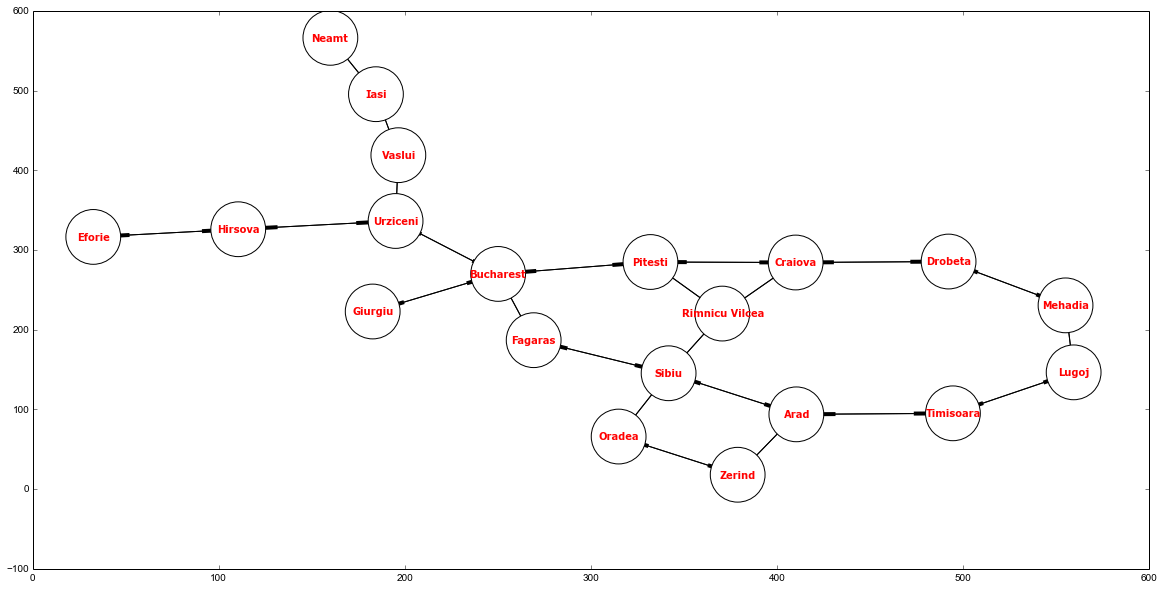

In [9]:
this_problem.view_graph()

In [10]:
class Node():
    def __init__(self, state, parent, action, path_cost):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost

In [11]:
start_node = Node('Sibiu', None, None, 0)

In [12]:
def child_node(problem, parent, action):
    '''return a node that is a child of given node'''
    new_state = problem.result(parent.state, action)
    this_cost = parent.path_cost + problem.cost(action)
    return Node(new_state, parent, action, this_cost)

In [13]:
available_actions = this_problem.available(start_node.state)
print available_actions

first_child = child_node(this_problem, start_node, available_actions[0])
print first_child.state

[('Rimnicu Vilcea', 80), ('Oradea', 151), ('Fagaras', 99), ('Arad', 140)]
Rimnicu Vilcea


In [14]:
def breadth_first_search(problem, start_node):
    if problem.goal_test(start_node.state):
        return start_node
    frontier = [start_node]
    frontier_states = {start_node.state}
    explored = set([])
    while(1):
        if len(frontier) == 0:
            return 'FAILURE'
        this_node = frontier.pop(0)
        frontier_states.remove(this_node.state)
        explored.add(this_node.state)
        #print explored
        for action in problem.available(this_node.state):
            this_child = child_node(problem, this_node, action)
            if (this_child.state not in explored) and (this_child.state not in frontier_states):
                if problem.goal_test(this_child.state):
                    return this_child
                frontier.append(this_child)
                frontier_states.add(this_child.state)

In [70]:
def uniform_cost_search(problem, start_node):
    if problem.goal_test(start_node.state):
        return start_node

    frontier = []
    heapq.heappush(frontier, (0, start_node))
    
    frontier_states = {start_node.state:start_node.path_cost}
    explored = set([])
    
    while(1):
        try:
            this_node = heapq.heappop(frontier)[1]
        except IndexError:
            return 'FAILURE' #heap was empty
                
        del frontier_states[this_node.state]
        if problem.goal_test(this_node.state):
            print this_node
            return this_node
        explored.add(this_node.state)
        for action in problem.available(this_node.state):
            this_child = child_node(problem, this_node, action)
            if (this_child.state not in explored) and (this_child.state not in frontier_states.keys()):
                heapq.heappush(frontier, (this_child.path_cost, this_child))
                frontier_states[this_child.state] = this_child.path_cost
            elif (this_child.state in frontier_states.keys()):
                if frontier_states[this_child.state] > this_child.path_cost:
                    frontier_states[this_child.state] = this_child.path_cost
                    heapq.heappush(frontier, (this_child.path_cost, this_child))

In [16]:
def solution(node):
    if node == 'FAILURE':
        print node
    else:
        path = []
        this_node = node
        while(this_node is not None):
            path.append(this_node.state)
            this_node = this_node.parent
        path.reverse()
        print path

In [17]:
solution(breadth_first_search(this_problem, start_node))

['Sibiu', 'Fagaras', 'Bucharest']


In [18]:
solution(uniform_cost_search(this_problem, start_node))

Sibiu
Rimnicu Vilcea
Fagaras
Arad
Oradea
Pitesti
Zerind
Craiova
Timisoara
Bucharest
<__main__.Node instance at 0x7f21133dda28>
['Sibiu', 'Rimnicu Vilcea', 'Pitesti', 'Bucharest']


In [19]:
def recursive_dls(this_node, problem, limit):
    if problem.goal_test(this_node.state):
        return this_node
    if limit == 0:
        return 'CUTOFF'
    cutoffp = False
    for action in problem.available(this_node.state):
        this_child = child_node(problem, this_node, action)
        result = recursive_dls(this_child, problem, limit-1)
        if result == 'CUTOFF':
            cutoffp = True
        elif result != 'FAILURE':
            return result
    if cutoffp:
        return 'CUTOFF'
    else:
        return 'FAILURE'
    
def depth_limited_search(problem, limit, start_node):
    return recursive_dls(start_node, problem, limit)

In [20]:
solution(depth_limited_search(this_problem, 9, start_node))

['Sibiu', 'Rimnicu Vilcea', 'Sibiu', 'Rimnicu Vilcea', 'Sibiu', 'Rimnicu Vilcea', 'Sibiu', 'Rimnicu Vilcea', 'Pitesti', 'Bucharest']


In [21]:
def iterative_deepening_search(this_problem, start_node):
    depth = 0
    while(1):
        result = depth_limited_search(this_problem, depth, start_node)
        if result != 'CUTOFF':
            return result
        depth += 1

In [22]:
solution(iterative_deepening_search(this_problem, start_node))

['Sibiu', 'Fagaras', 'Bucharest']


# Sliding Block Puzzle

In [48]:
#map blank index to available moves
allowed_actions = {0:('R','D')
                  ,1:('L','D','R')
                  ,2:('L','D')
                  ,3:('U','R','D')
                  ,4:('U','R','D','L')
                  ,5:('U','L','D')
                  ,6:('U','R')
                  ,7:('U','R','L')
                  ,8:('U','L')}

class SlidingBlock3(Problem):
    def __init__(self):
        pass
    
    def result(self, state, action):
        assert action in self.available(state)
        new_state = list(state)
        blank_index = state.index(0)
        if action == 'R':
            moved_block_loc = blank_index+1
        elif action == 'L':
            moved_block_loc = blank_index-1
        elif action == 'U':
            moved_block_loc = blank_index-3
        elif action == 'D':
            moved_block_loc = blank_index+3
            
        
        moved_block = state[moved_block_loc]
        new_state[blank_index] = moved_block
        new_state[moved_block_loc] = 0
        
        return tuple(new_state)
    
    def available(self, state):
        blank_index = state.index(0)
        return allowed_actions[blank_index]
    
    def cost(self, action):
        return 1
    
    def goal_test(self, state):
        return state == tuple(range(9))
    
def solution_sbp(node):
    if node == 'FAILURE':
        print node
    else:
        path = []
        this_node = node
        while(this_node is not None):
            path.append(this_node.action)
            this_node = this_node.parent
        path.reverse()
        print path[1:]

In [52]:
start_sbp = Node((1,0,2,3,4,5,6,7,8), None, None, 0)

this_sbp = SlidingBlock3()

solution_sbp(iterative_deepening_search(this_sbp, start_sbp))

['L']


In [97]:
from random import choice

#generate random problem instance
def random_sbp(num_moves):
    start = tuple(range(9))

    this_state = tuple(range(9))
    for ii in range(num_moves):
        next_move = choice(this_sbp.available(this_state))
        this_state = this_sbp.result(this_state, next_move)

    return this_state

In [98]:
random_sbp_node = Node(random_sbp(20), None, None, 0)
solution_sbp(breadth_first_search(this_sbp, random_sbp_node))

['L', 'L', 'U', 'U']


# Heuristics

In [82]:
def h_1(state):
    '''returns the number of misplaced tiles in the nine-puzzle'''
    matches = 0
    for b1, b2 in zip(state, range(9)):
        if b1 == b2 and b1!=0:
            matches += 1
    return (8-matches)

test_h_state = tuple([7, 2, 4, 5, 0, 6, 8, 3, 1])
assert h_1(test_h_state) == 8

In [90]:
def h_2(state):
    '''returns sum of manhattan distances of tiles from correct place'''
    hh = 0
    for bb, pp in zip(state, range(9)):
        hh += manhattan_distance(bb, pp)
    return hh

def manhattan_distance(bb, pp):
    if bb == 0:
        return 0
    md = abs(bb % 3- pp%3) + abs(bb/3 - pp/3)
    return md

assert h_2(test_h_state)  == 18

In [95]:
def a_star_search(problem, start_node):
    if problem.goal_test(start_node.state):
        return start_node

    frontier = []
    heapq.heappush(frontier, (0, start_node))
    
    eval_cost = start_node.path_cost + h_2(start_node.state)
    
    frontier_states = {start_node.state:eval_cost}
    explored = set([])
    
    while(1):
        try:
            this_node = heapq.heappop(frontier)[1]
        except IndexError:
            return 'FAILURE' #heap was empty
                
        del frontier_states[this_node.state]
        if problem.goal_test(this_node.state):
            print this_node
            return this_node
        explored.add(this_node.state)
        for action in problem.available(this_node.state):
            this_child = child_node(problem, this_node, action)
            eval_cost = this_child.path_cost + h_2(this_child.state)
            if (this_child.state not in explored) and (this_child.state not in frontier_states.keys()):
                heapq.heappush(frontier, (eval_cost, this_child))
                frontier_states[this_child.state] = eval_cost
            elif (this_child.state in frontier_states.keys()):
                if frontier_states[this_child.state] > eval_cost:
                    frontier_states[this_child.state] = eval_cost
                    heapq.heappush(frontier, (eval_cost, this_child))

In [109]:
random_sbp_node = Node(random_sbp(100), None, None, 0)
solution_sbp(a_star_search(this_sbp, random_sbp_node))

<__main__.Node instance at 0x7f21095554d0>
['U', 'R', 'D', 'L', 'D', 'R', 'U', 'U', 'L', 'D', 'R', 'D', 'L', 'U', 'L', 'U']
